# Tensorflow Tutorial

In this file, I will follow the Tensorflow official tutorial to learn Tensorflow. The examples are from https://www.tensorflow.org/get_started/, https://www.tensorflow.org/tutorials/, and https://github.com/aymericdamien/TensorFlow-Examples. In the meantime, I probably will have my own small projects using Tensorflow. 

## Getting Started

In [1]:
import tensorflow as tf

The computational graph: Tensorflow Core programs consist of two discrete sections
1) Building the comptational graph
2) Ruing the computational graph
Computational graph is a series Tensorflow operations arranged into a graph of nodes. Let's build a simple computational graph. Each node takes zero or more tensors as inputs and produces a tensor as an output. 

In [3]:
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0)
node3 = tf.constant(5.0)
print node1, node2, node3

Tensor("Const_2:0", shape=(), dtype=float32) Tensor("Const_3:0", shape=(), dtype=float32) Tensor("Const_4:0", shape=(), dtype=float32)


To actually evaluate the nodes, we must run the computational graph within a session. A session encapsulates the control and state of the Tensorflow runtime. Create a Session object, and invoke its run method to run enough of the computational graph to evaluate. 

In [5]:
session = tf.Session()
print session.run(node1 + node2)
print session.run([node1, node2])

7.0
[3.0, 4.0]


We can build more complicated computation by combining tensor nodes with operations.

In [7]:
node4 = tf.add(node1, node2)
print "node4:", node4
print "session.run(node4)", session.run(node4)

node4: Tensor("Add:0", shape=(), dtype=float32)
session.run(node4) 7.0


A graph can be parameterized to accept external inputs, known as placeholders. A placeholder is a promise to provide a value later

In [8]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
adder_note = a + b
print session.run(adder_note, {a: 3, b: 4.5})
print session.run(adder_note, {a: [1, 3], b: [2, 4]})

7.5
[ 3.  7.]


and then even more complex:

In [9]:
add_and_triple = adder_note * 3
print session.run(add_and_triple, {a: 3, b: 4.5})

22.5


To make machine learning model trainable, we need to be able to modify the graph to get new outputs with the same input. Variables allow us to add trainable parameters to graph. Variables are not initialised when we call tf.Variable. To initialize all variables in a Tensorflow programe, we have to explicitly call a special operation

In [11]:
W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b
init = tf.global_variables_initializer()
session.run(init)
print session.run(linear_model, {x:[1,2,3,4]})

[ 0.60000002  0.90000004  1.20000005  1.5       ]


In [13]:
y = tf.placeholder(tf.float32)
squared_delta = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_delta)
print session.run(loss, {x:[1,2,3,4], y:[0,-1,-2,-3]})

34.46


In [14]:
fixW = tf.assign(W, [-1])
fixb = tf.assign(b, [1.])
session.run([fixW, fixb])
print session.run(loss, {x:[1,2,3,4], y:[0,-1,-2,-3]})

0.0


Tensorflow provides optimizers that slowly change each variable in order to minimize the loss function. The simplest optimizer is gradient descent. it modifies each variable according to the magnitude of the derivatives of loss with respect to that variable. Tensorflow can automatically produce deritives given only a description of the model using function tf.gradients.  

In [16]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)
session.run(init)
for i in range(1000):
    session.run(train, {x:[1,2,3,4], y:[0,-1,-2,-3]})
    
print(session.run([W, b]))
print(session.run(loss, {x:[1,2,3,4], y:[0,-1,-2,-3]}))

[array([-0.99999791], dtype=float32), array([ 0.99999392], dtype=float32)]
2.52847e-11


tf.contrib.learn is a high-level Tensorflow library that simplifies the mechanisms of machine learning, including 1) running training loops 2) running evaluation loops, 3) managing data sets, 4) managing feeding.
Basic useage: a much simpler linear regression program

In [168]:
import tensorflow as tf
import numpy as np
features = [tf.contrib.layers.real_valued_column("x", dimension=1)]
estimator = tf.contrib.learn.LinearRegressor(feature_columns=features)
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0.])
input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_train}, y_train, batch_size=4, num_epochs=1000)
eval_input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_eval}, y_eval, batch_size=4, num_epochs=1000)
estimator.fit(input_fn=input_fn, steps=1000)
train_loss = estimator.evaluate(input_fn=input_fn)
eval_loss = estimator.evaluate(input_fn=eval_input_fn)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print "train loss: %r" % train_loss
print "evaluation loss: %r" % eval_loss

train loss: {'loss': 1.0086203e-06, 'global_step': 1000}
evaluation loss: {'loss': 0.0026156974, 'global_step': 1000}


A custom model:

In [23]:
tf.logging.set_verbosity(tf.logging.ERROR) # turn off warning

In [24]:
import tensorflow as tf
import numpy as np

def model(features, labels, mode):
    W = tf.get_variable("W", [1], dtype=tf.float64)
    b = tf.get_variable("b", [1], dtype=tf.float64)
    y = W * features['x'] + b
    loss = tf.reduce_sum(tf.square(y - labels))
    globe_step = tf.train.get_global_step()
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = tf.group(optimizer.minimize(loss),
                     tf.assign_add(globe_step, 1))
    return tf.contrib.learn.ModelFnOps(mode=mode, predictions=y, loss=loss, train_op=train)

estimator = tf.contrib.learn.Estimator(model_fn=model)
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0.])
input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_train}, y_train, 4, num_epochs=1000)
eval_input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_eval}, y_eval, batch_size=4, num_epochs=1000)
estimator.fit(input_fn=input_fn, steps=1000)
train_loss = estimator.evaluate(input_fn=input_fn)
eval_loss = estimator.evaluate(input_fn=eval_input_fn)
print "train loss: %r" % train_loss
print "evaluation loss: %r" % eval_loss

train loss: {'loss': 2.4748615e-11, 'global_step': 1000}
evaluation loss: {'loss': 0.010100762, 'global_step': 1000}


## Basic Models
### MNIST Example 

Read data

In [25]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Nearest neighbour model
Some basic models:
The first model, nearest neighbour model

In [179]:
# build the graph
x_train, y_train = mnist.train.next_batch(20000)
x_test, y_test = mnist.test.next_batch(2000)

xtr_v = tf.placeholder("float", [None, 784])
xte_v = tf.placeholder("float", [784])

distance = tf.reduce_sum(tf.abs(tf.add(xtr_v, tf.negative(xte_v))), reduction_indices=1)
pred = tf.arg_min(distance, 0)
accuracy = 0.
init = tf.global_variables_initializer()

# launch the graph
with tf.Session() as sess:
    sess.run(init)    
    for i in range(x_test.shape[0]):
        nn_index =  sess.run(pred, feed_dict={xtr_v:x_train, xte_v: x_test[i, :]})
        # print "Test", i, "Prediction:", np.argmax(y_train[nn_index]), "True Class:", np.argmax(y_test[i])
        if np.argmax(y_train[nn_index]) == np.argmax(y_test[i]):
            accuracy += 1./x_test.shape[0]
print "Done! Accuracy: %f" % accuracy

Done! Accuracy: 0.952000


In [37]:
session.run(distance, {xtr_v:x_train, xte_v: x_test[i, :]})

array([ 129.21961975,  131.29019165,  136.71372986, ...,  120.22745514,
        142.92156982,  138.54508972], dtype=float32)

### Linear regression
### House price prediction in Boston area


The second model: Linear regression, example house price prediction in Boston area

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np

from numpy import genfromtxt
from sklearn.datasets import load_boston

# load data
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)

def read_boston_data():
    boston = load_boston()
    features = np.array(boston.data)
    labels = np.array(boston.target)
    return features, labels

def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

features,labels = read_boston_data()
normalized_features = feature_normalize(features)
f, l = append_bias_reshape(normalized_features,labels)
n_dim = f.shape[1]

rnd_indices = np.random.rand(len(f)) < 0.80

train_x = f[rnd_indices]
train_y = l[rnd_indices]
test_x = f[~rnd_indices]
test_y = l[~rnd_indices]


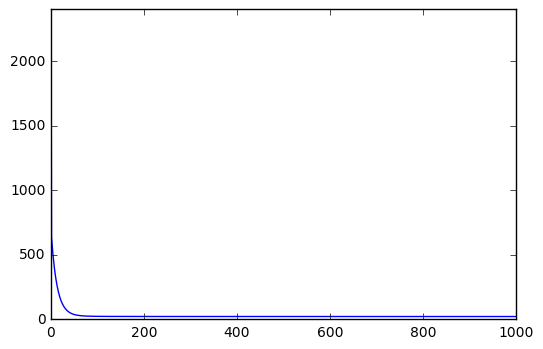

In [164]:
learning_rate = 0.01
training_epochs = 1000
rng = np.random
cost_history = np.empty(shape=[1],dtype=np.float32)
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(rng.randn(n_dim, 1), name="weight", dtype=tf.float32)
b = tf.Variable(rng.randn(), name="bias", dtype=tf.float32)

y_ = tf.matmul(X, W) + b
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))
    
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 19.7016


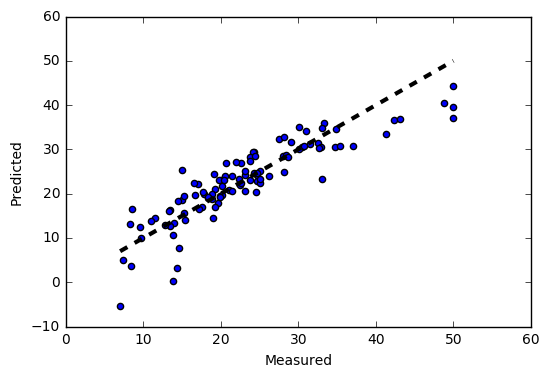

In [165]:
pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Goodness-of-fit: a common way to summarize how well a linear regression model fits the data is via the coefficient of determination or R^2. This is calculated as the square of correlation between the observed y values and the predicted value y_hat. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [166]:
from sklearn.metrics import r2_score
print "R2 score: %f" % r2_score(test_y, pred_y)

R2 score: 0.774475


### Nonlinear regression
use an one hidden layer neural network as a regression model 

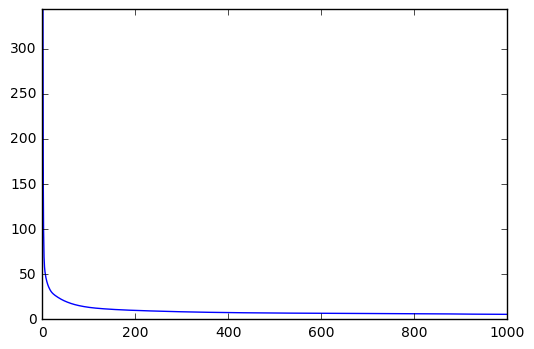

In [157]:
learning_rate = 0.05
momentum = 0.9
training_epochs = 1000
hidden = 9
cost_history = np.empty(shape=[1],dtype=float)
X = tf.placeholder(tf.float32,[None, n_dim])
Y = tf.placeholder(tf.float32,[None, 1])
W1 = tf.Variable(rng.randn(n_dim, hidden), name="weight", dtype=tf.float32)
b1 = tf.Variable(rng.randn(hidden), name="bias", dtype=tf.float32)
W2 = tf.Variable(rng.randn(hidden, 1), name="weight", dtype=tf.float32)
b2 = tf.Variable(rng.randn(), name="bias", dtype=tf.float32)
h1 = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
y_ = tf.matmul(h1, W2) + b2
cost = tf.reduce_mean(tf.square(y_ - Y))
# training_step = tf.train.AdagradDAOptimizer(learning_rate).minimize(cost)
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# training_step = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
# training_step = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True).minimize(cost)
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))
    
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 7.5087


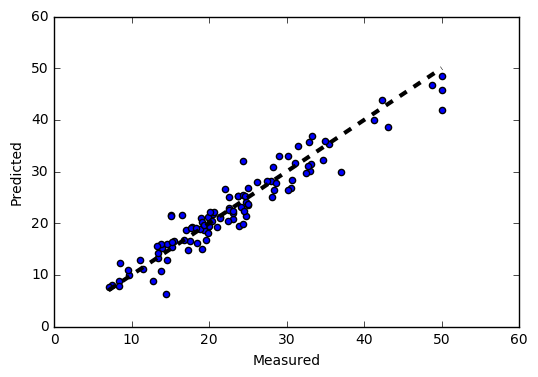

In [158]:
pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [159]:
from sklearn.metrics import r2_score
print "R2 score: %f" % r2_score(test_y, pred_y)

R2 score: 0.914047


Nonlinear regression: use an one hidden layer neural network as a regression model (tensorflow layer implementation)

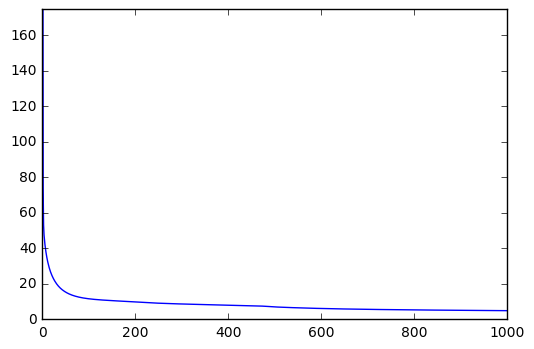

In [161]:
learning_rate = 0.05
momentum = 0.9
training_epochs = 1000
hidden = 9

X = tf.placeholder(tf.float32,[None, n_dim])
Y = tf.placeholder(tf.float32,[None, 1])
cost_history = np.empty(shape=[1],dtype=np.float32)
layer1 = tf.layers.dense(X, hidden, activation=tf.nn.sigmoid)
Wo = tf.Variable(rng.randn(hidden, 1), name="weight", dtype=tf.float32)
bo = tf.Variable(rng.randn(), dtype=tf.float32)
y_ = tf.matmul(layer1, Wo) + bo

cost = tf.reduce_mean(tf.square(y_ - Y))
# training_step = tf.train.AdagradDAOptimizer(learning_rate).minimize(cost)
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# training_step = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
# training_step = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True).minimize(cost)
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))
    
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 8.3247


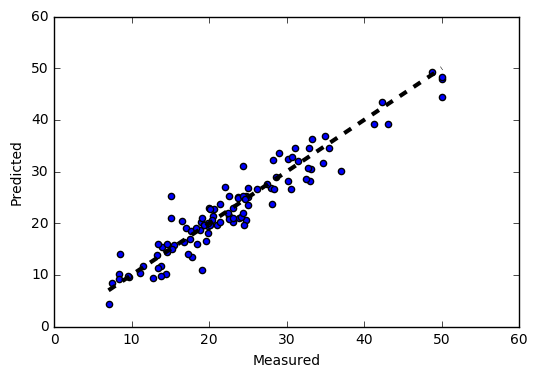

In [162]:
pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [163]:
from sklearn.metrics import r2_score
print "R2 score: %f" % r2_score(test_y, pred_y)

R2 score: 0.904707


### Logistic regression
Using MNIST data

 Epoch: 0010 cost= 1.293231719
Epoch: 0020 cost= 0.928310808
Epoch: 0030 cost= 0.790747981
Epoch: 0040 cost= 0.713607731
Epoch: 0050 cost= 0.655491050
Epoch: 0060 cost= 0.619245792
Epoch: 0070 cost= 0.588894196
Epoch: 0080 cost= 0.563403022
Epoch: 0090 cost= 0.540182225
Epoch: 0100 cost= 0.519066210
Accuracy: 0.883667


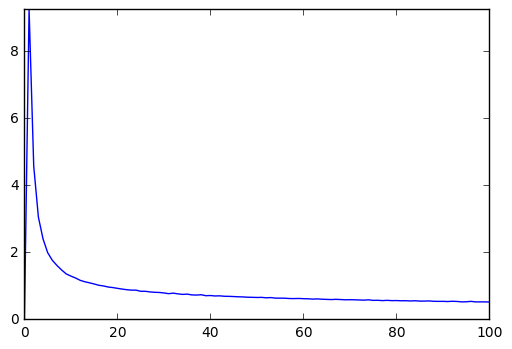

In [177]:
import tensorflow as tf
import numpy as np
learning_rate = 0.01
training_epoch = 100
batch_size = 100
display_step = 10
ndim = 784
nclass = 10
rng = np.random
cost_history = np.empty(shape=[1],dtype=float)

x = tf.placeholder(tf.float32, [None, ndim])
y = tf.placeholder(tf.float32, [None, nclass])

W = tf.Variable(rng.randn(ndim, nclass), name='weights', dtype=tf.float32)
b = tf.Variable(rng.randn(nclass), name='bias', dtype=tf.float32)
y_ = tf.nn.softmax(tf.matmul(x, W) + b)
# minimizing cross entropy
# y_ = tf.nn.softmax(tf.matmul(x, W) + b)
# cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_), reduction_indices=1))

# directly use tf.nn.softmax_cross_entropy_with_logits
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tf.matmul(x, W) + b, labels=y))

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for epoch in xrange(training_epoch):
    total_batch = int(mnist.train.num_examples/batch_size)
    avg_cost = 0.
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c = sess.run([optimizer, cost], feed_dict={x:batch_xs, y:batch_ys})
        avg_cost += c / total_batch        
    if (epoch+1) % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)    
    cost_history = np.append(cost_history,avg_cost)
    
# Test model
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
# Calculate accuracy for 3000 examples
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print "Accuracy:", accuracy.eval(session=sess, feed_dict={x: mnist.test.images[:3000], 
                                                          y: mnist.test.labels[:3000]})

plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epoch,0,np.max(cost_history)])
plt.show()

### Deep Neural Networks
Build a Multilayer Convolutional Network

In [203]:
import tensorflow as tf
ndim = 784
n_classes = 10
num_epochs = 100
cost_history = np.empty(shape=[1],dtype=float)
batch_size = 100
learning_rate = 0.01
# initialize variable
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Convolution and Pooling
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

# weights and bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': weight_variable([5, 5, 1, 32]),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': weight_variable([5, 5, 32, 64]),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': weight_variable([7*7*64, 1024]),
    # 1024 inputs, 10 outputs (class prediction)
    'out': weight_variable([1024, n_classes])
}

biases = {
    'bc1': bias_variable([32]),
    'bc2': bias_variable([64]),
    'bd1': bias_variable([1024]),
    'out': bias_variable([n_classes])
}

# input and labels
x = tf.placeholder(tf.float32, [None, ndim])
y = tf.placeholder(tf.float32, [None, n_classes])
dropout = tf.placeholder(tf.float32)

# create model
# def conv_net(x, weights, bias, dropout):
input_x = tf.reshape(x, shape=[-1, 28, 28, 1])
conv1 = conv2d(input_x, weights['wc1'], biases['bc1'])
conv1 = maxpool2d(conv1, k=2) # downsampling

conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
conv2 = maxpool2d(conv2, k=2)

# fully connected

fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
fc1 = tf.matmul(fc1, weights['wd1']) + biases['bd1']
# batch normalization
fc1 = tf.contrib.layers.batch_norm(fc1, center=True, scale=True)
fc1 = tf.nn.relu(fc1)

# Apply Dropout
fc1 = tf.nn.dropout(fc1, dropout)

y_ = tf.nn.softmax(tf.matmul(fc1, weights['out']) + biases['out'])
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_), reduction_indices=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in xrange(num_epochs):
        total_batch = int(mnist.train.num_examples/batch_size)
        avg_cost = 0.
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c = sess.run([optimizer, cost], feed_dict={x:batch_xs, y:batch_ys,
                                                          dropout:0.75})
            avg_cost += c / total_batch
            
        if (epoch+1) % display_step == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={x: mnist.test.images[3000:6000],
                                                              y: mnist.test.labels[3000:6000],
                                                              dropout: 1.})
            print "Epoch:", '%3d' % (epoch+1), "cost=%.5f" % loss, "accuracy=%.5f" % acc 
        cost_history = np.append(cost_history,avg_cost)
        
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
# Calculate accuracy for 3000 examples
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print "Accuracy:", accuracy.eval(session=sess, feed_dict={x: mnist.test.images[:3000], 
                                                          y: mnist.test.labels[:3000],
                                                          dropout: 1.})

plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epoch,0,np.max(cost_history)])
plt.show()

Epoch: 0010 cost= 0.010 accuract=

ValueError: Unknown format code 'f' for object of type 'str'

In [211]:
print "Epoch:", '%3d' % (epoch+1), "cost=%.5f" % loss, "accuracy=%.5f" % acc

Epoch:  10 cost=0.00994 accuracy=1.00000


10000